<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/BDML_202520/blob/main/Lecture02/L02_Coef_Computation.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

#  Bottlenecks in Everyday Data Analytics Tasks

*taken from Big Data Analytics by Ulrich Matter*

The objective of this section is to broaden the perspective section focuses on the statistics perspective: compute something in a different way (with a different algorithm) but end up with essentially the same result. It is also an illustration of how diverse the already implemented solutions for working with large data in applied econometrics in the R-universe are, and how it makes sense to first look into a more efficient algorithm/statistical procedure than directly use specialized packages such as bigmemory or even scale up in the cloud. 


## Efficient fixed effects estimation

Here we look into a very common computational problem in applied econometrics: estimation of a fixed effects model with various fixed-effects units (i.e., many intercepts). 

We aim to give an illustration of how a specific statistical procedure can help us reduce the computational burden substantially (here, by reducing the number of columns in the model matrix and therefore the burden of computing the inverse of a huge model matrix). 

As an example we will use the study called ["Friends in High Places"](https://www.aeaweb.org/articles?id=10.1257/pol.6.3.63) by Cohen and Malloy. They show that US Senators who are alumni of the same university/college tend to help each other out in votes on industrial policies if the corresponding policy is highly relevant for the state of one senator but not relevant for the state of the other senator. 


In [1]:
install.packages("pacman") #Correr esta linea en Google Colab


The downloaded binary packages are in
	/var/folders/43/ks5b0qkj0l54138f3c8hv7jr0000gp/T//RtmpQoN9lW/downloaded_packages


In [2]:
# Cargamos los paquetes

require("pacman")

p_load("tidyverse","stargazer","data.table","lmtest","foreign")


Loading required package: pacman



In [3]:
# Need to set up, the package is in our repo, but it's too big to have it unzipped.
#https://github.com/ignaciomsarmiento/datasets/blob/main/114873-V1.zip

DATA_PATH <- "data_for_tables.dta"

# import data
cm <- as.data.table(read.dta(DATA_PATH))
# keep only clean obs
cm <- cm[!(is.na(yes)
           |is.na(pctsumyessameparty)
           |is.na(pctsumyessameschool)
           |is.na(pctsumyessamestate))] 


As an example we will replicate parts of Table 3 of the main article (p. 73). Specifically, we will estimate specifications (1) and (2). 

In both specifications, the dependent variable is an indicator `yes` that is equal to 1 if the corresponding senator voted Yes on the given bill and 0 otherwise. 

The main explanatory variables of interest are:

   - `pctsumyessameschool` (the percentage of senators from the same school as the corresponding senator who voted Yes on the given bill), 
   - `pctsumyessamestate` (the percentage of senators from the same state as the corresponding senator who voted Yes on the given bill), and 
   - `pctsumyessameparty` (the percentage of senators from the same party as the corresponding senator who voted Yes on the given bill). 
     
     
Specification 1 accounts for congress (time) fixed effects and senator (individual) fixed effects, and specification 2 accounts for congress-session-vote fixed effects and senator fixed effects. 

First, let us look at a very simple example to highlight where the computational burden in the estimation of such specifications is coming from. 

In terms of the regression model 1, the fixed effect\index specification means that we introduce an indicator variable (an intercept) for $N-1$ senators and $M-1$ congresses. That is, the simple model matrix ($X$) without accounting for fixed effects has dimensions 

$$
425653\times 4
$$. 

In [4]:
# pooled model (no FE)
model0 <-   yes ~ 
  pctsumyessameschool + 
  pctsumyessamestate + 
  pctsumyessameparty 

dim(model.matrix(model0, data=cm))

[1] 425653      4

In contrast, the model matrix of specification (1) is of dimensions 

$$ 
425653\times 221 
$$, 

and the model matrix of specification (2) even of 

$$
425653\times6929
$$.


In [5]:
model1 <- 
  yes ~ pctsumyessameschool + 
        pctsumyessamestate + 
        pctsumyessameparty + 
        factor(congress) +
        factor(id) -1
mm1 <- model.matrix(model1, data=cm)
dim(mm1)

[1] 425653    168

Using OLS to estimate such a model thus involves the computation of a very large matrix inversion (because $\hat{\beta}_{OLS} = (\mathbf{X}^\intercal\mathbf{X})^{-1}\mathbf{X}^{\intercal}\mathbf{y}$). I

n addition, the model matrix for specification 2 is about 22GB, which might further slow down the computer due to a lack of physical memory or even crash the R session altogether.

In order to set a point of reference, we first estimate specification (1) with standard OLS.


In [6]:
# fit specification (1)
runtime <- system.time(fit1 <- lm(data = cm, formula = model1))
coeftest(fit1)[2:4,]


,Estimate,Std. Error,t value,Pr(>|t|)
pctsumyessamestate,0.11860868,0.001085411,109.275390,0.00000000
pctsumyessameparty,0.92640204,0.001397477,662.910254,0.00000000
factor(congress)101,-0.01458354,0.006428673,-2.268515,0.02329834


In [7]:
# median amount of time needed for estimation (in seconds)
runtime[3]

elapsed 
 11.112

As expected, this takes more time to compute. However, there is an alternative approach to estimating such models that substantially reduces the computational burden by "sweeping out the fixed effects dummies". In the simple case of only one fixed effect variable (e.g., only individual fixed effects), the trick is called "within transformation" or "demeaning" and is quite simple to implement. 

For each of the categories in the fixed effect variable, compute the mean of the covariate and subtract the mean from the covariate's value.

In [8]:
# illustration of within transformation for the senator fixed effects
cm_within <- 
  with(cm, data.table(yes = yes - ave(yes, id),
                      pctsumyessameschool = pctsumyessameschool -
                        ave(pctsumyessameschool, id),
                      pctsumyessamestate = pctsumyessamestate -
                        ave(pctsumyessamestate, id),
                      pctsumyessameparty = pctsumyessameparty -
                        ave(pctsumyessameparty, id)
                      ))

# comparison of dummy fixed effects estimator and within estimator
dummy_time <- system.time(fit_dummy <- 
              lm(yes ~ pctsumyessameschool + 
                       pctsumyessamestate +
                       pctsumyessameparty + 
                       factor(id) -1, data = cm
                         ))
within_time <- system.time(fit_within <- 
                             lm(yes ~ pctsumyessameschool +
                                      pctsumyessamestate + 
                                      pctsumyessameparty -1, 
                                      data = cm_within))
# computation time comparison
as.numeric(within_time[3])/as.numeric(dummy_time[3])


[1] 0.004141644

In [9]:

# comparison of estimates
coeftest(fit_dummy)[1:3,]
coeftest(fit_within)

,Estimate,Std. Error,t value,Pr(>|t|)
pctsumyessameschool,0.04424462,0.001351867,32.72852,1.204583e-234
pctsumyessamestate,0.11863874,0.001085427,109.30143,0.000000e+00
pctsumyessameparty,0.92615124,0.001397064,662.92687,0.000000e+00



t test of coefficients:

                     Estimate Std. Error t value  Pr(>|t|)    
pctsumyessameschool 0.0442446  0.0013516  32.734 < 2.2e-16 ***
pctsumyessamestate  0.1186387  0.0010852 109.322 < 2.2e-16 ***
pctsumyessameparty  0.9261512  0.0013968 663.048 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Unfortunately, we cannot simply apply the same procedure in a specification with several fixed effectsvariables. However, there are packages that  provide a generalization of the linear within-estimator to several fixed effects  variables. 

One of these  is implemented in the `lfe` package. With this package, we can easily estimate both fixed-effect specifications (as well as the corresponding cluster-robust standard errors) in order to replicate the original results by Cohen and Malloy.


In [10]:
p_load("lfe")

# model and clustered SE specifications
model1 <- yes ~ pctsumyessameschool + 
                pctsumyessamestate + 
                pctsumyessameparty |congress+id|0|id
model2 <- yes ~ pctsumyessameschool + 
                pctsumyessamestate + 
                pctsumyessameparty |congress_session_votenumber+id|0|id

# estimation
fit1 <- felm(model1, data=cm)
fit2 <- felm(model2, data=cm)


Finally we can display the regression table.

In [11]:
stargazer::stargazer(fit1,fit2,
                     type="text",
                     dep.var.labels = "Vote (yes/no)",
                     covariate.labels = c("School Connected Votes",
                                          "State Votes",
                                          "Party Votes"),
                     keep.stat = c("adj.rsq", "n"))



                           Dependent variable:     
                       ----------------------------
                              Vote (yes/no)        
                            (1)            (2)     
---------------------------------------------------
School Connected Votes    0.045***      0.052***   
                          (0.016)        (0.016)   
                                                   
State Votes               0.119***      0.122***   
                          (0.013)        (0.012)   
                                                   
Party Votes               0.926***      0.945***   
                          (0.022)        (0.024)   
                                                   
---------------------------------------------------
Observations              425,653        425,653   
Adjusted R2                0.641          0.641    
Note:                   *p<0.1; **p<0.05; ***p<0.01


<div >
<img src = "figs/table3_cohen_malloy.png" />
</div>

# Computing the OLS Coefficients

- Using matrix algebra, the loss function:

$$
\tilde \epsilon' \tilde \epsilon  = (y-X \tilde \beta)'(y-X \tilde \beta)
$$

  - $SSR(\tilde \beta)$ is the aggregation of squared errors if we choose $\tilde \beta$ as an estimator.

- The **least squares estimator $\hat \beta$** will be:

$$
\hat \beta = \underset{\tilde \beta}{\text{argmin}}\, SSR(\tilde \beta)
$$

## Traditional Computation using Normal Equations


Let's illustrate this in R

Creamos unos datos de juguete para ilustrar:

In [12]:
dta<-tibble(lnwage=c(5,10,12.50),educ=c(8,12,16))
dta

lnwage,educ
<dbl>,<dbl>
5.0,8
10.0,12
12.5,16


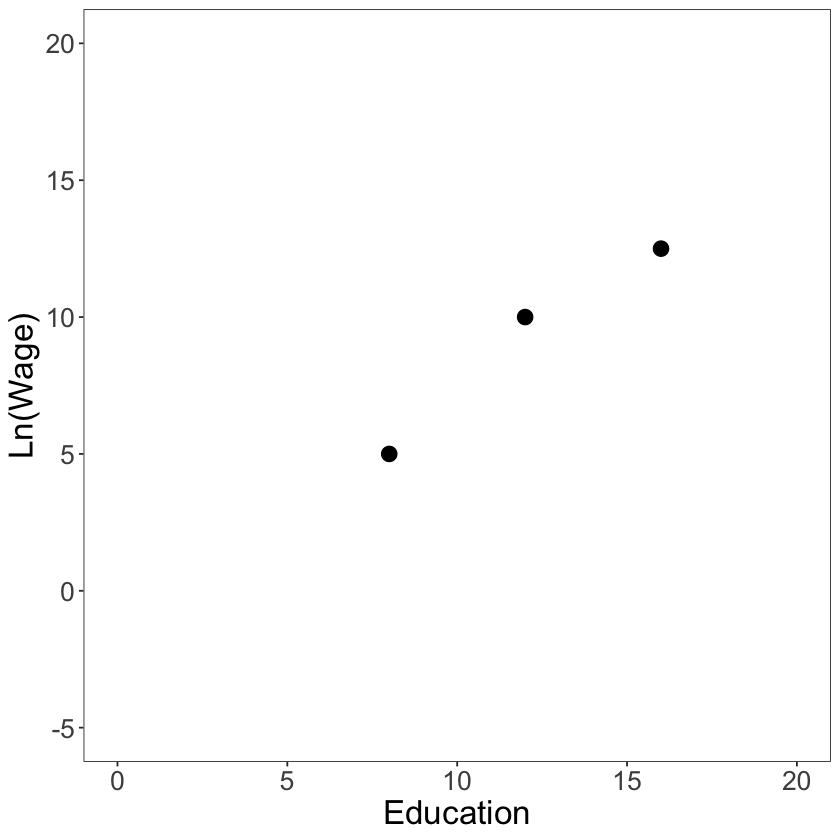

In [13]:
ggplot(dta,aes(x=educ,y=lnwage)) +
  geom_point(alpha=1,size=4) +
  theme_bw()  +
  xlab("Education") +
  ylab("Ln(Wage)") +
  xlim(0,20) +
  ylim(-5,20) +
  theme(legend.position = "none",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        text = element_text(size=20)
  )


In [14]:
# dependant variable as a one-column matrix, i.e., a vector
y<-matrix(dta$lnwage,ncol=1)

# the design matrix
X<-model.matrix(~educ,data=dta)

X

,(Intercept),educ
1,1,8
2,1,12
3,1,16


$$
\hat{\beta} = (X'X)^{-1}X'y
$$

In [15]:
beta_coef<-solve(t(X)%*%X)%*%t(X)%*%y

beta_coef

(Intercept),-2.083333
educ,0.937500


In [16]:
reg_with_lm<- lm(lnwage~educ,data=dta)

In [17]:
reg_with_lm


Call:
lm(formula = lnwage ~ educ, data = dta)

Coefficients:
(Intercept)         educ  
    -2.0833       0.9375  


In [18]:
str(reg_with_lm)

List of 12
 $ coefficients : Named num [1:2] -2.083 0.937
  ..- attr(*, "names")= chr [1:2] "(Intercept)" "educ"
 $ residuals    : Named num [1:3] -0.417 0.833 -0.417
  ..- attr(*, "names")= chr [1:3] "1" "2" "3"
 $ effects      : Named num [1:3] -15.88 -5.3 -1.02
  ..- attr(*, "names")= chr [1:3] "(Intercept)" "educ" ""
 $ rank         : int 2
 $ fitted.values: Named num [1:3] 5.42 9.17 12.92
  ..- attr(*, "names")= chr [1:3] "1" "2" "3"
 $ assign       : int [1:2] 0 1
 $ qr           :List of 5
  ..$ qr   : num [1:3, 1:2] -1.732 0.577 0.577 -20.785 -5.657 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:3] "1" "2" "3"
  .. .. ..$ : chr [1:2] "(Intercept)" "educ"
  .. ..- attr(*, "assign")= int [1:2] 0 1
  ..$ qraux: num [1:2] 1.58 1.26
  ..$ pivot: int [1:2] 1 2
  ..$ tol  : num 1e-07
  ..$ rank : int 2
  ..- attr(*, "class")= chr "qr"
 $ df.residual  : int 1
 $ xlevels      : Named list()
 $ call         : language lm(formula = lnwage ~ educ, data = dta)
 $ terms     

## Traditional Computation using QR Decomposition

- To avoid inverting $X'X$, we can use matrix decomposition: **QR decomposition**.
- Most software uses this technique.


In [19]:
lm.fit(X,y)$coefficients

(Intercept)        educ 
  -2.083333    0.937500

In [20]:
#?lm.fit

**Theorem:**
If $A \in \mathbb{R}^{n \times k}$, there exists an orthogonal $Q \in \mathbb{R}^{n \times k}$ and an upper triangular $R \in \mathbb{R}^{k \times k}$ such that $A = QR$.

### Properties:
- Orthogonal Matrices:
  - Definition: $Q'Q = QQ' = I$ and $Q' = Q^{-1}$
  - Property: The product of orthogonal matrices is orthogonal. For example, if $A'A = I$ and $B'B = I$, then $(AB)'(AB) = B'(A'A)B = B'B = I$.
- **Thin QR:** If $A \in \mathbb{R}^{n \times k}$ has full column rank, then $A = Q_1R_1$, where $Q_1 \in \mathbb{R}^{n \times k}$, and $R$ is upper triangular with positive diagonal entries.





How does it work to get $\ hat\beta$?

- Solve by back substitution

1. QR factorization: $X'X = QR$

In [21]:
QR<-qr(X)

In [22]:
R<- qr.R(QR)
R

,(Intercept),educ
1,-1.732051,-20.784610
2,0.000000,-5.656854


In [23]:
Q<- qr.Q(QR)
Q

-0.5773503,7.071068e-01
-0.5773503,1.110223e-16
-0.5773503,-7.071068e-01


2. Calculate $Q'y$.

In [24]:
t(Q)%*%y

-15.877132
-5.303301





3. Solve:







In [25]:
beta1<-  -5.303301/-5.656854
beta1

[1] 0.9375001

In [26]:
beta0<- (-15.877132 -  (-20.784610*beta1)) /-1.732051
beta0

[1] -2.083334

In [27]:
lm.fit(X,y)$coefficients

(Intercept)        educ 
  -2.083333    0.937500

### Householder transformation (Extra)


There are many ways to implement the QR decomposition, like the Gram-Schmidt process and the Household transformation. 
In R, the QR decomposition used in functions like `lm()` is implemented via Householder reflections, a standard and numerically stable algorithm for computing the QR decomposition implemented using the [LAPACK library](https://www.netlib.org/lapack/).

Householder reflections are much more stable than the Gram-Schmidt process, which can accumulate rounding errors, and the algorithms are quite efficient for moderate data sets.

To illustrate the **Householder transformation** for the QR decomposition in your linear regression example, we can explicitly perform the steps of the algorithm. The goal is to decompose $ \mathbf{X} $ into $ \mathbf{Q} $ and $ \mathbf{R} $, where $ \mathbf{Q} $ is orthogonal and $ \mathbf{R} $ is upper triangular. The algorithm for the QR decomposition can be summarized as:

**Input**: Matrix $ \mathbf{X} $ of size $ n \times k $.  
**Output**: Matrices $ \mathbf{Q} $ (orthogonal) and $ \mathbf{R} $ (upper triangular).


##### **Steps**
1. **Initialize**:
   - Let $ \mathbf{Q} = \mathbf{I}_n $ (identity matrix of size $ n \times n $).
   - Let $ \mathbf{R} = \mathbf{X} $.

2. **Iterate over each column of $ \mathbf{X} $**:
   - For $ j = 1, 2, \dots, k $:
     1. Extract the column $ \mathbf{r}_j = \mathbf{R}[j:n, j] $ (the portion below and including the diagonal).
     2. Compute the **norm** of $ \mathbf{r}_j $:  
        $ \text{norm} = \|\mathbf{r}_j\|_2 = \sqrt{\sum (\mathbf{r}_j^2)} $.
     3. Construct the **reflection vector** $ \mathbf{v} $:
        - $ \mathbf{v} = \mathbf{r}_j $
        - Modify the first element of $ \mathbf{v} $:  
          $ \mathbf{v}[1] = \mathbf{r}_j[1] + \text{sign}(\mathbf{r}_j[1]) \cdot \text{norm} $.
        - Normalize $ \mathbf{v} $:  
          $ \mathbf{v} = \mathbf{v} / \|\mathbf{v}\|_2 $.
     4. Form the **Householder matrix** $ \mathbf{H}_j $:
        - $ \mathbf{H}_j = \mathbf{I} - 2 \mathbf{v} \mathbf{v}^\top $.
        - Expand $ \mathbf{H}_j $ to size $ n \times n $ by applying it to rows $ j $ to $ n $ only.
     5. Apply $ \mathbf{H}_j $ to $ \mathbf{R} $:
        - $ \mathbf{R} = \mathbf{H}_j \mathbf{R} $.
     6. Accumulate $ \mathbf{Q} $:
        - $ \mathbf{Q} = \mathbf{Q} \cdot \mathbf{H}_j^\top $.

3. **Finalize**:
   - The resulting $ \mathbf{Q} $ is orthogonal, and $ \mathbf{R} $ is upper triangular.

Here's how we can approach this in R, step by step:

##### Step 1: Define the Design Matrix

We take our design matrix $\mathbf{X}$ 


In [28]:
X

,(Intercept),educ
1,1,8
2,1,12
3,1,16


##### Step 2: Apply the Householder Transformation
The Householder transformation is applied to zero out the sub-diagonal entries of the first column of $ \mathbf{X}$ , then the second column, and so on.



###### First Reflection
1. Define the first column $ \mathbf{x}_1 $ of $ \mathbf{X}$.
2. Compute the reflection vector $ \mathbf{v} $ and construct the Householder matrix $ \mathbf{H}_1 $.


In [29]:
householder <- function(x) {
  # Compute the norm of x
  norm_x <- sqrt(sum(x^2))
  
  # Define the reflection vector v
  v <- x
  v[1] <- x[1] + sign(x[1]) * norm_x
  
  # Normalize v
  v <- v / sqrt(sum(v^2))
  
  # Construct the Householder matrix
  H <- diag(length(x)) - 2 * v %*% t(v)
  
  return(H)
}


In [30]:
# First column of X
x1 <- X[, 1]

# Apply Householder transformation for the first column
H1 <- householder(x1)

H1

1,2,3
-0.5773503,-0.5773503,-0.5773503
-0.5773503,0.7886751,-0.2113249
-0.5773503,-0.2113249,0.7886751


In [31]:
# Transform X
X1 <- H1 %*% X
X1

(Intercept),educ
-1.732051,-20.784610
0.000000,1.464102
0.000000,5.464102


#####  Second Reflection
We now apply a second Householder transformation to the second column of $ \mathbf{X}_1$, ignoring the first row (already triangular).


In [32]:
# Extract the second column below the diagonal
x2 <- X1[2:3, 2]

# Apply Householder transformation
H2_partial <- householder(x2)

# Expand H2 to be a full matrix
H2 <- diag(3)
H2[2:3, 2:3] <- H2_partial

H2

1,0.0000000,0.0000000
0,-0.2588190,-0.9659258
0,-0.9659258,0.2588190


In [33]:
# Transform X1
X2 <- H2 %*% X1
X2

(Intercept),educ
-1.732051,-2.078461e+01
0.000000,-5.656854e+00
0.000000,1.110223e-15


At this stage, $\mathbf{X}_2$ is fully upper triangular.

##### Step 3: Combine Householder Matrices
The overall $ \mathbf{Q} $ matrix is the product of the Householder matrices:
$$
\mathbf{Q} = H_1^\top H_2^\top
$$

In [34]:
Qhoush <- t(H2) %*% t(H1)
Qhoush

-0.5773503,-5.773503e-01,-0.5773503
0.7071068,1.942890e-16,-0.7071068
0.4082483,-8.164966e-01,0.4082483


In [35]:
Rhouse<-X2


In [36]:
round(Rhouse,2)

(Intercept),educ
-1.73,-20.78
0.00,-5.66
0.00,0.00


In [37]:
round(R,2)

,(Intercept),educ
1,-1.73,-20.78
2,0.00,-5.66


**Why the Last Row of $ \mathbf{R} $ in the Householder transformation is Zero?**

The matrix $ \mathbf{R} $ is the result of applying the Householder transformations to $ \mathbf{X} $. If $ \mathbf{X} $ has more rows ($ n $) than columns ($ k $), the matrix $ \mathbf{R} $ will have a size $ n \times k $, but:

1. **Triangular Shape**: $ \mathbf{R} $ is upper triangular by definition.
   - The first $ k $ rows of $ \mathbf{R} $ contain meaningful values.
   - The remaining $ n - k $ rows (if $ n > k $) are all zeros because the decomposition process eliminates entries below the main diagonal for each column of $ \mathbf{X} $.

2. **Overdetermined Systems**: In regression, $ n > k $ is common because there are more observations than predictors.
   - After applying the Householder reflections, the additional rows beyond the $ k $-th row become zeros due to the nature of the decomposition.


**What R's `qr()` Function Does**
In R, the `qr()` function is designed to return a compact representation of $ \mathbf{R} $:
- **Truncated $ \mathbf{R} $**: The function returns only the first $ k $ rows of $ \mathbf{R} $, as the remaining $ n - k $ rows are guaranteed to be zeros and contain no additional information.
- This behavior intentionally saves memory and focuses on the part of $ \mathbf{R} $ that is meaningful for solving the regression problem.


## Traditional Computation using SVD Decomposition

The **Singular Value Decomposition (SVD)** provides a robust method for solving linear regression problems, particularly when the design 
matrix $ \mathbf{X} $ is ill-conditioned or rank-deficient. For a matrix $ \mathbf{X} $ of size $ n \times k $, the SVD is:

$$
\mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top,
$$

where $ \mathbf{U} $ ($ n \times n $) and $ \mathbf{V} $ ($ k \times k $) are orthogonal matrices, and $ \mathbf{\Sigma} $ ($ n \times k $) is a diagonal matrix containing the singular values of $ \mathbf{X} $, denoted as $ \sigma_1, \sigma_2, \ldots, \sigma_r $ ($ r $ is the rank of $ \mathbf{X} $).

To solve the regression $ \mathbf{y} = \mathbf{X} \mathbf{\beta} + \mathbf{\epsilon} $, the coefficients $ \mathbf{\beta} $ are estimated using the pseudoinverse of $ \mathbf{X} $:

$$
\mathbf{\beta} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y} = \mathbf{V} \mathbf{\Sigma}^+ \mathbf{U}^\top \mathbf{y},
$$

where $ \mathbf{\Sigma}^+ $ is the pseudoinverse of $ \mathbf{\Sigma} $, obtained by inverting the nonzero singular values and transposing the matrix. This method is numerically stable and handles cases where $ \mathbf{X} $ is not full rank.

This is the way that is solved in `Python` by [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) that leverages [LAPACK](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lstsq.html) (Linear Algebra PACKage)

## Big Data and Machine Learning Way: Gradient Descent

<div>
    <img src="figs/meme_gradient_descent.png"  style="width: 300px;" />
</div>

- Gradient Descent is a generic optimization algorithm that finds optimal solutions to various problems.
- The general idea is to tweak parameters iteratively to minimize a risk function:

$$
\text{min}_f E[L(y_i, f(\boldsymbol{X_i}))]
$$

### Computing OLS Coefficients

The problem is to estimate the coefficients of vector $\beta$ that minimize the objective function:

$$
\text{argmin}_\beta \sum_{i=1}^{n} \frac{1}{n} \left(y_i - \beta_0 - \sum_{k=1}^K X_k \beta_k\right)^2
$$



#### Intuition: Loss Function (1D and 2D)

##### **1D Loss Function:**

<div >
<img src = "figs/reg0.png"   style="width: 800px;"  />
</div>

#####  **2D Loss Function:**


<div >
<img src = "figs/ols1.png"  style="width: 800px;" />
</div>



#### The algorithm

<div >
<img src = "figs/step_size1.png"  style="width: 800px;" />
</div>





1. Randomly pick starting values for the parameters.
2. Compute the gradient of the objective function at the current parameter values using all observations from the sample.
3. Update the parameters.
4. Repeat from step 2 until a fixed number of iterations or convergence.



In `R`

In [38]:
gradiente_alpha<-function(alpha,beta){ -(2/3)*((5-alpha-beta*8)+(10-alpha-beta*12)+(12.5-alpha-beta*16))}
gradiente_beta<-function(alpha,beta){ -(2/3)*(8*(5-alpha-beta*8)+12*(10-alpha-beta*12)+16*(12.5-alpha-beta*16))}


# Empty vector
alpha<-list()
beta<-list()

# First Values
alpha[[1]]<- -1
beta[[1]]<- 2

# Learning Rate
epsilon<-0.005

# Second iteration
j<-2

alpha[[j]]<-alpha[[j-1]]-epsilon*gradiente_alpha(alpha[[j-1]],beta[[j-1]])
beta[[j]]<- beta[[j-1]]-epsilon*gradiente_beta(alpha[[j-1]],beta[[j-1]])



In [39]:
alpha[[j]]

[1] -1.138333

In [40]:
beta[[j]]

[1] 0.2266667

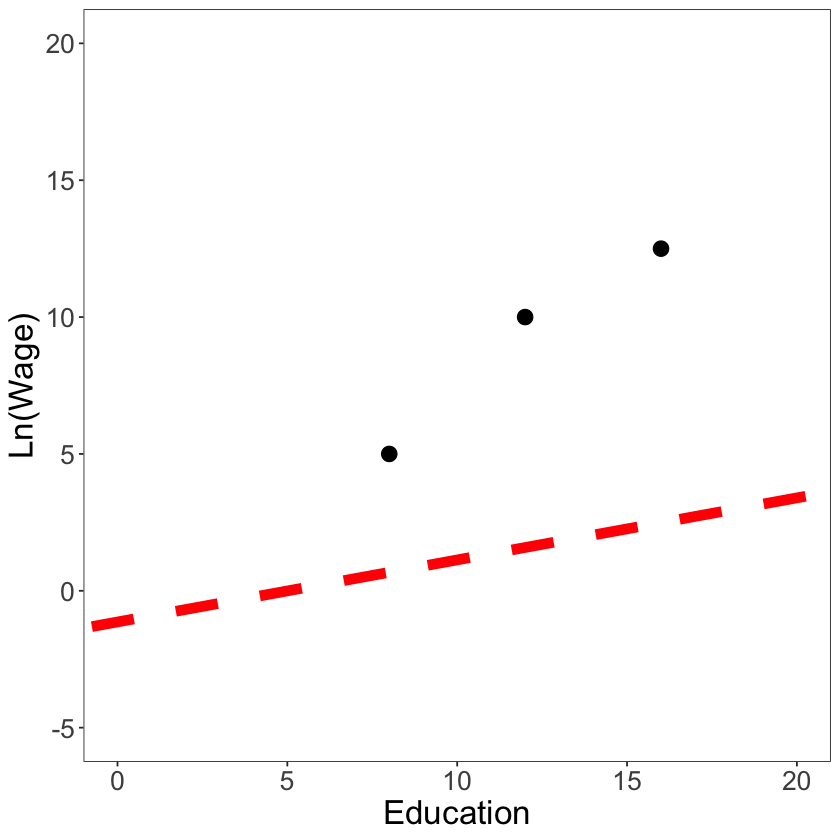

In [41]:
ggplot(dta,aes(x=educ,y=lnwage)) +
  geom_point(alpha=1,size=4) +
  theme_bw()  +
  xlab("Education") +
  ylab("Ln(Wage)") +
  xlim(0,20) +
  ylim(-5,20) +
  geom_abline(intercept = alpha[[j]], slope = beta[[j]],linewidth=3, col="red",lty="dashed") +
  theme(legend.position = "none",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        text = element_text(size=20)
  ) 



In [42]:
j<-3

alpha[[j]]<-alpha[[j-1]]-epsilon*gradiente_alpha(alpha[[j-1]],beta[[j-1]])
beta[[j]]<- beta[[j-1]]-epsilon*gradiente_beta(alpha[[j-1]],beta[[j-1]])


In [43]:
alpha

[[1]]
[1] -1

[[2]]
[1] -1.138333

[[3]]
[1] -1.062483

In [44]:
beta

[[1]]
[1] 2

[[2]]
[1] 0.2266667

[[3]]
[1] 1.212689

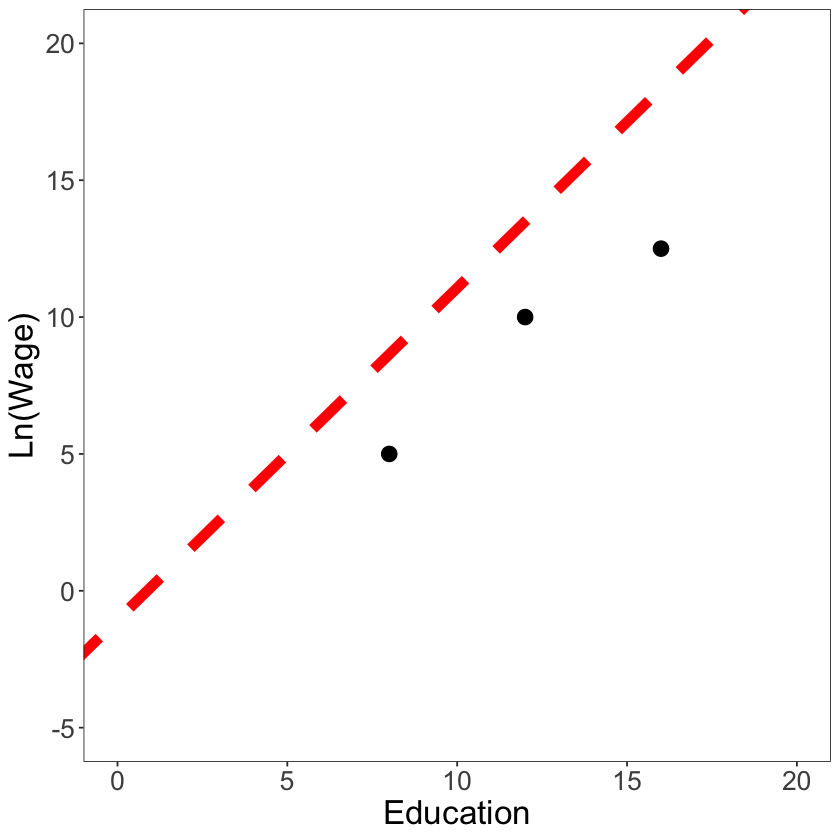

In [45]:
ggplot(dta,aes(x=educ,y=lnwage)) +
  geom_point(alpha=1,size=4) +
  theme_bw()  +
  xlab("Education") +
  ylab("Ln(Wage)") +
  xlim(0,20) +
  ylim(-5,20) +
  geom_abline(intercept = alpha[[j]], slope = beta[[j]],linewidth=3, col="red",lty="dashed") +
  theme(legend.position = "none",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        text = element_text(size=20)
  ) 


In [46]:
i<-2
tol<-0.000001

difff<-2

Loss<-function(alpha,beta){ 1/3*((5-alpha-beta*8)+(10-alpha-beta*12)+(12.5-alpha-beta*16))}

while( (difff>tol)==TRUE ){
  
  alpha[[i+1]]<- alpha[[i]]- epsilon*gradiente_alpha(alpha[[i]],beta[[i]])
  beta[[i+1]] <- beta[[i]] - epsilon*gradiente_beta(alpha[[i]],beta[[i]])
  
  difff<-abs(Loss(alpha[[i]],beta[[i]])-Loss(alpha[[i-1]],beta[[i-1]]))
  
  i<-i+1
  print(i)
}






[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10
[1] 11
[1] 12
[1] 13
[1] 14
[1] 15
[1] 16
[1] 17
[1] 18
[1] 19
[1] 20
[1] 21
[1] 22
[1] 23
[1] 24
[1] 25
[1] 26
[1] 27
[1] 28
[1] 29
[1] 30
[1] 31
[1] 32
[1] 33
[1] 34
[1] 35
[1] 36
[1] 37
[1] 38
[1] 39
[1] 40
[1] 41
[1] 42
[1] 43
[1] 44
[1] 45
[1] 46
[1] 47
[1] 48
[1] 49
[1] 50
[1] 51
[1] 52
[1] 53
[1] 54
[1] 55
[1] 56
[1] 57
[1] 58
[1] 59
[1] 60
[1] 61
[1] 62
[1] 63
[1] 64
[1] 65
[1] 66
[1] 67
[1] 68
[1] 69
[1] 70
[1] 71
[1] 72
[1] 73
[1] 74
[1] 75
[1] 76
[1] 77
[1] 78
[1] 79
[1] 80
[1] 81
[1] 82
[1] 83
[1] 84
[1] 85
[1] 86
[1] 87
[1] 88
[1] 89
[1] 90
[1] 91
[1] 92
[1] 93
[1] 94
[1] 95
[1] 96
[1] 97
[1] 98
[1] 99
[1] 100
[1] 101
[1] 102
[1] 103
[1] 104
[1] 105
[1] 106
[1] 107
[1] 108
[1] 109
[1] 110
[1] 111
[1] 112
[1] 113
[1] 114
[1] 115
[1] 116
[1] 117
[1] 118
[1] 119
[1] 120
[1] 121
[1] 122
[1] 123
[1] 124
[1] 125
[1] 126
[1] 127
[1] 128
[1] 129
[1] 130
[1] 131
[1] 132
[1] 133
[1] 134
[1] 135
[1] 136
[1] 137
[1] 138
[1] 139
[1] 140


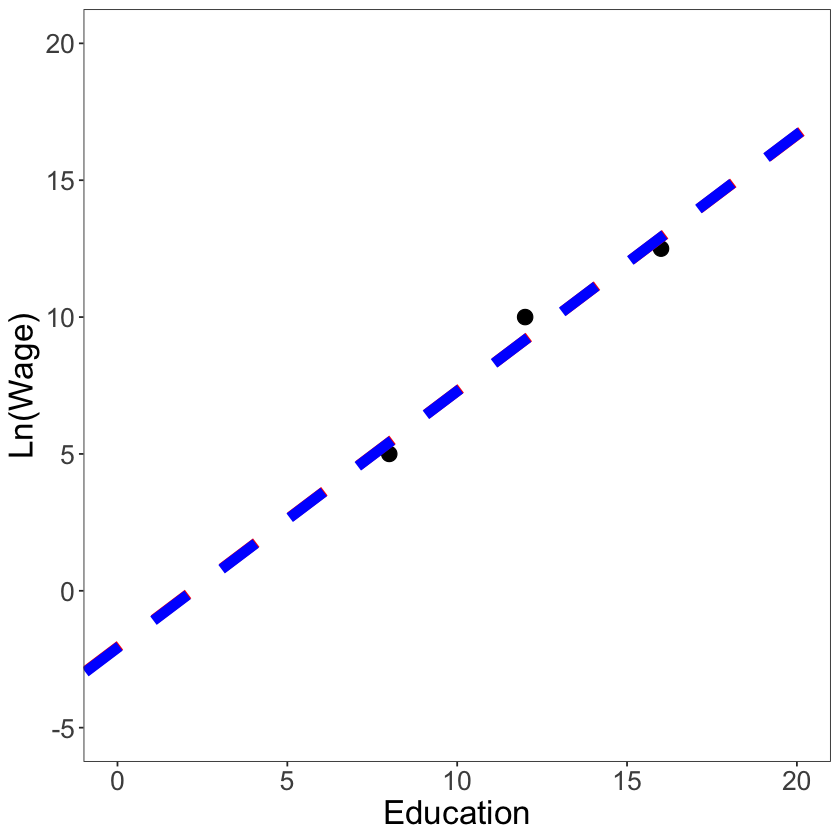

In [47]:
ggplot(dta,aes(x=educ,y=lnwage)) +
  geom_point(alpha=1,size=4) +
  theme_bw()  +
  xlab("Education") +
  ylab("Ln(Wage)") +
  xlim(0,20) +
  ylim(-5,20) +
  geom_abline(intercept = alpha[[i]], slope = beta[[i]],linewidth=3, col="red",lty="dashed") +
  geom_abline(intercept = lm.fit(X,y)$coefficients[1], slope = lm.fit(X,y)$coefficients[2],linewidth=3, col="blue",lty="dashed") +
  theme(legend.position = "none",
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        text = element_text(size=20)
  ) 


### The learning rate

We can choose $\epsilon$ in several different ways:

 - Set $\epsilon$ to a small constant. (like before)
 


<div >
<img src = "figs/step_size2.png"  style="width: 800px;"/>
</div>

- Use varying learning rates (*more on this later*)

## Computational Complexity

| **Method**             | **Computational Complexity**                     | **Description**                                                                                     | **Large $k$** | **Large $n$** | **Hyperparameters** |
|-------------------------|--------------------------------------------------|-----------------------------------------------------------------------------------------------------|----------------|----------------|----------------------|
| **Inverting $ \mathbf{X}'\mathbf{X} $** | $ \mathcal{O}(nk^2 + k^3) $                    | Direct computation using $ \mathbf{\beta} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y} $. Requires inversion of $ \mathbf{X}^\top \mathbf{X} $, which is costly for large $k$. | Slow               | Slow               | 0                    |
| **QR Decomposition**   | $ \mathcal{O}(nk^2) $                          | Used in R's `lm()`. Solves $ \mathbf{X}^\top \mathbf{X} \mathbf{\beta} = \mathbf{X}^\top \mathbf{y} $ via QR decomposition. Efficient for moderate $k$. | Fast               | Slow               | 0                    |
| **SVD**                | $ \mathcal{O}(nk^2 + k^3) $                    | Used in Python's `scikit-learn`. Computes $ \mathbf{X} = \mathbf{U} \mathbf{\Sigma} \mathbf{V}^\top $. Provides numerical stability. Suitable for ill-conditioned matrices. | Fast               | Slow               | 0                    |
| **Gradient Descent**   | $ \mathcal{O}(n k \cdot \text{iter}) $          | Iterative method. $ \text{iter} $ is the number of iterations required for convergence. Efficient for very large $n$. | Slow               | Fast               | 2                    |
